# Optimal Private Minimim Spanning Trees using Input Perturbation

## General Information

Notebook to reproduce our experiments.

**Problem**: We consider the problem of privately releasing an MST for a graph $G$ where both the set of
vertices $V = \{1, ..., n\}$ and edges E are public, but we keep the weights $\vec{W}\in \mathbb{R}$ private.
We are using $\rho$-zCDP under the $\ell_\infty$ neighboring relationship with the following mechanisms:

## The Mechanisms

**PAMST** (Pinot 2018): Prim-based using the Report-Noisy-max with exponential noise $(n-1)$ times for selection.
returns $\arg\min_{e \in Cut} w_e + Exp(\frac{\epsilon}{2\Delta_\infty})$.

**Sealfon**: Uses the Post-Processing approach suggested by Sealfon. 
Releases the full noisy graph and hence returns $\vec{W} + N(0, \sigma^2)$ for $\sigma = \sqrt{\frac{n}{2\rho}}$ 

**We** Modification of Sealfon.
We add Gumble noise to each of the edges and therefore set $w_e' = \log(Exp(1)) + \lambda \cdot w_e$ where $\lambda = \sqrt{\frac{n-1}{2\cdot\rho}} \cdot 2 \cdot\Delta_\infty$



In [1]:
import logging
import math, sys
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from src.mst.mst_utilities import (compute_real_mst_weight, 
                                   generate_random_complete_graph, 
                                   compute_input_perturbation, 
                                   generate_hard_instance, 
                                   compute_approximate_dp, 
                                   generate_mi_instance, 
                                   generate_random_erdos_reny_graph,)
from src.util.ioutils import save_results, load_results, encode_experiment_one, save_plot_and_data
from src.mst.visualization_tools import init_plot, init_multiplot

sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})

from src.util.logging_utils import init_logger
logger = init_logger(logging.INFO)
if sys.version_info[0:2] != (3, 9):
    logger.warning("This script has only been tested on python 3.9")

## Experiment 1: Complete Graph

The following uses a complete graph with edge weights uniformly drawn from $Uni(0,a)$ for some $a$.

 2024-11-13 09:32:04,559 - INFO - Loading from disk. file 'save/complete_n500_sens1_range0-50x.npy'.


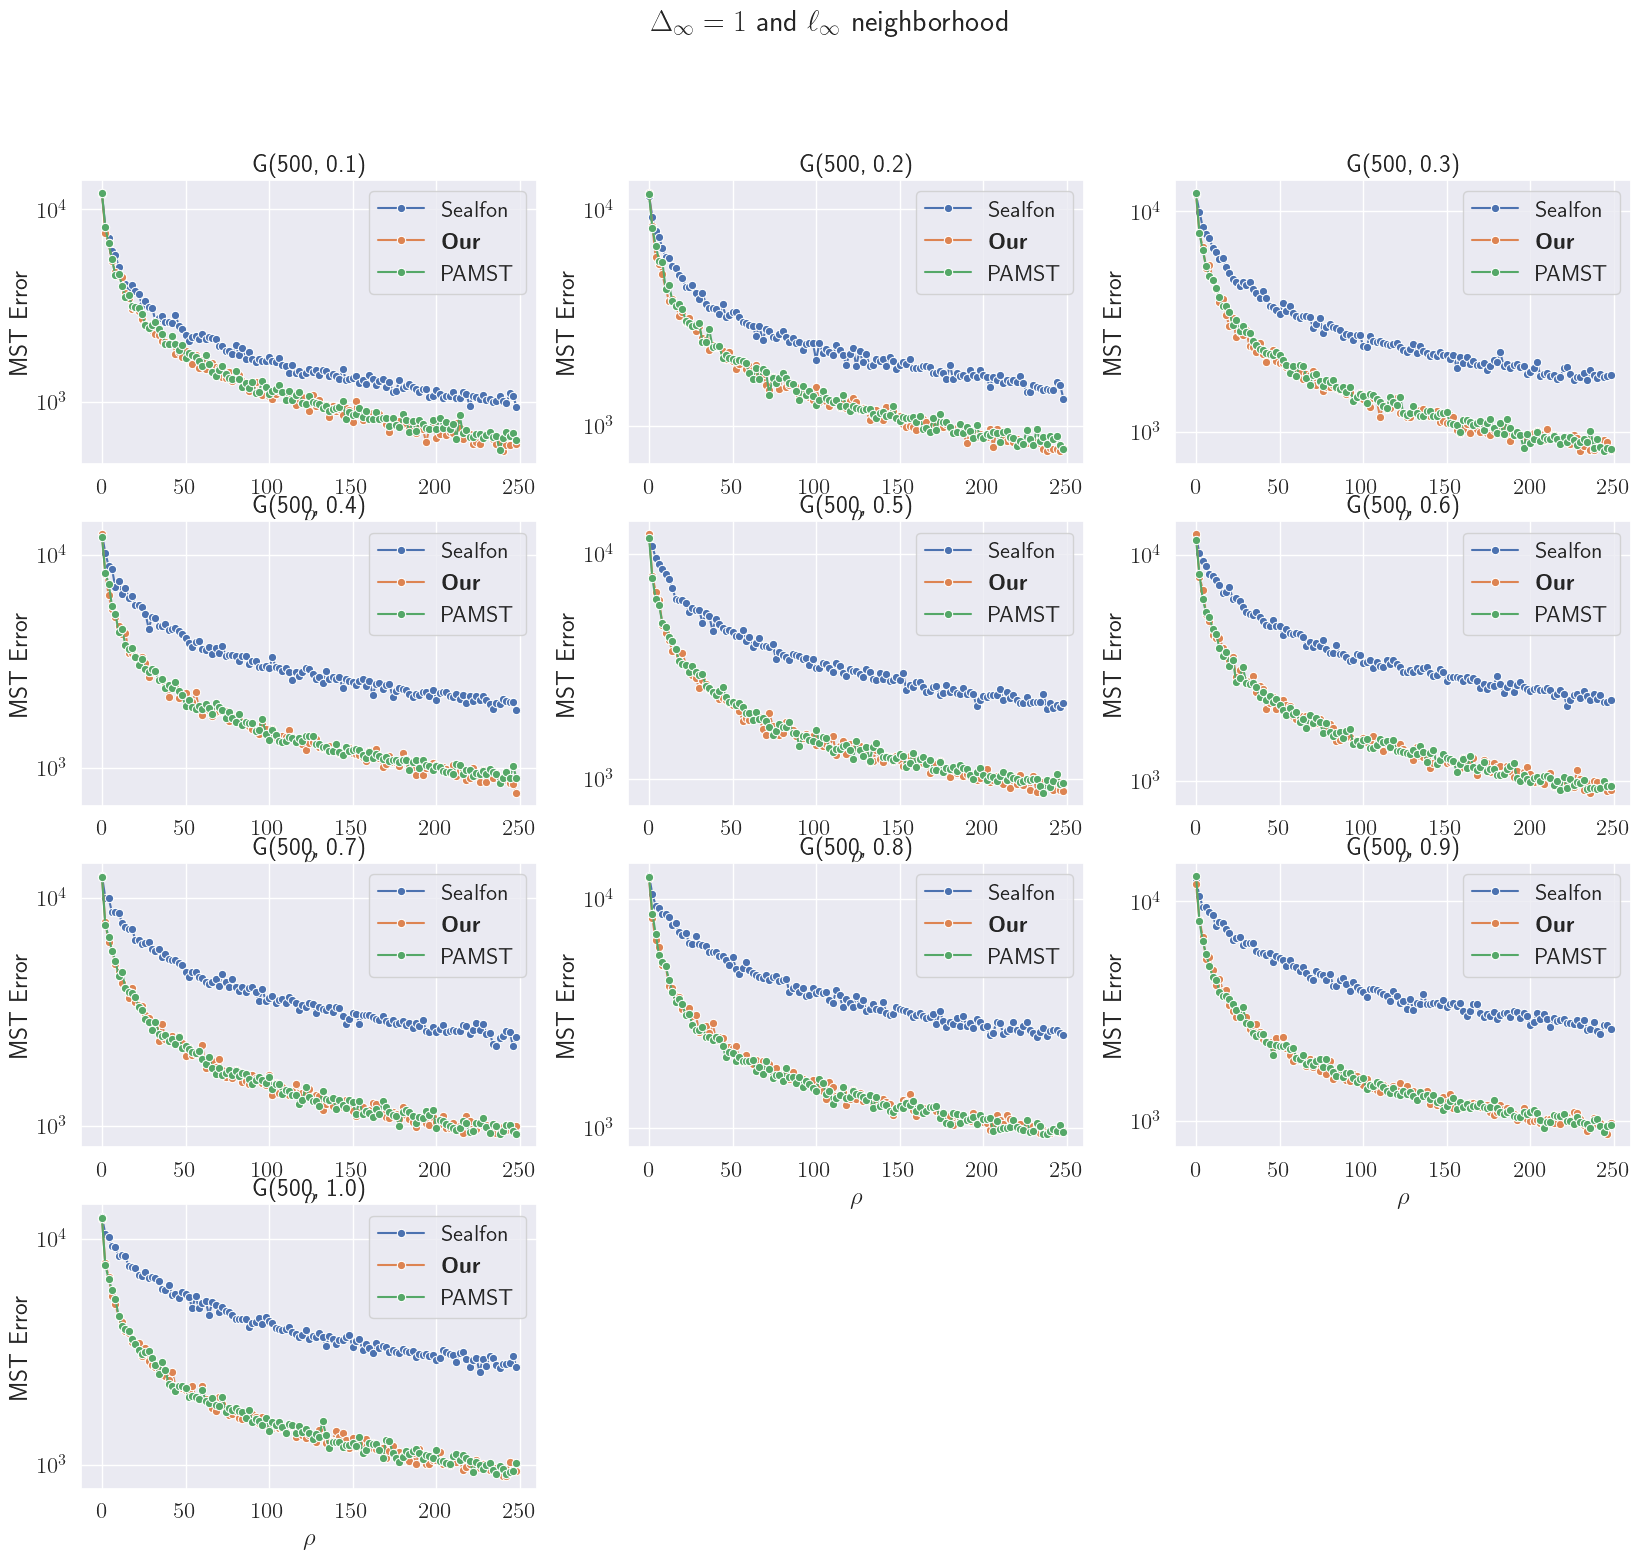

In [7]:
# Meta Parameters
load_from_disk = True
filename_to_load = "save/complete_n500_sens1_range0-50x.npy"

if load_from_disk:
    logger.info("Loading from disk. file '{}'.".format(filename_to_load))
    res = load_results(filename=filename_to_load)
    (results_complete, edge_probabilities, rho_values, n, maximum_edge_weight, sensitivity) = \
        (res["results"], res["edge_probabilities"], res["rho_values"], res["n"], res["maximum_edge_weight"], res["sensitivity"])
else:
    # Parameters for Graph Structure
    n = 500
    maximum_edge_weight = 50 # upper limit of edge weight
    edge_probabilities = np.linspace(0.1,1.0,10) # Graph Densitites
    # Privacy Parameters
    sensitivity = 1
    rho_values = np.arange(0.001, 250, 2)
    results_complete = []
    
    for edge_p in edge_probabilities:
        logger.debug("working on G({},{})".format(n, edge_p))
        if edge_p < np.log2(n)/n: logger.warning("Graph might not be connected as p < log(n)/n!")
        G = generate_random_erdos_reny_graph(n, p=edge_p, max_edge_weight=maximum_edge_weight)
        results_complete += [compute_approximate_dp(G=G, sensitivity=sensitivity, rho_values=rho_values)]
    logger.info("computation complete. Initializing the plots.")

# Initialized Plots
init_multiplot(results_complete, rho_values,
               meta_params={
                   'graph-size': n,
                   'title': "$\\Delta_\\infty={}$ and $\\ell_\\infty$ neighborhood".format(sensitivity),
                    'edge_probabilities': edge_probabilities,
               }, columns=3)

# Saving the results if specified
if not load_from_disk:
    save_plot_and_data(results_complete, edge_probabilities, rho_values, n, maximum_edge_weight, sensitivity)
    
plt.show()

# Experiment 2: Instance with Mutual information

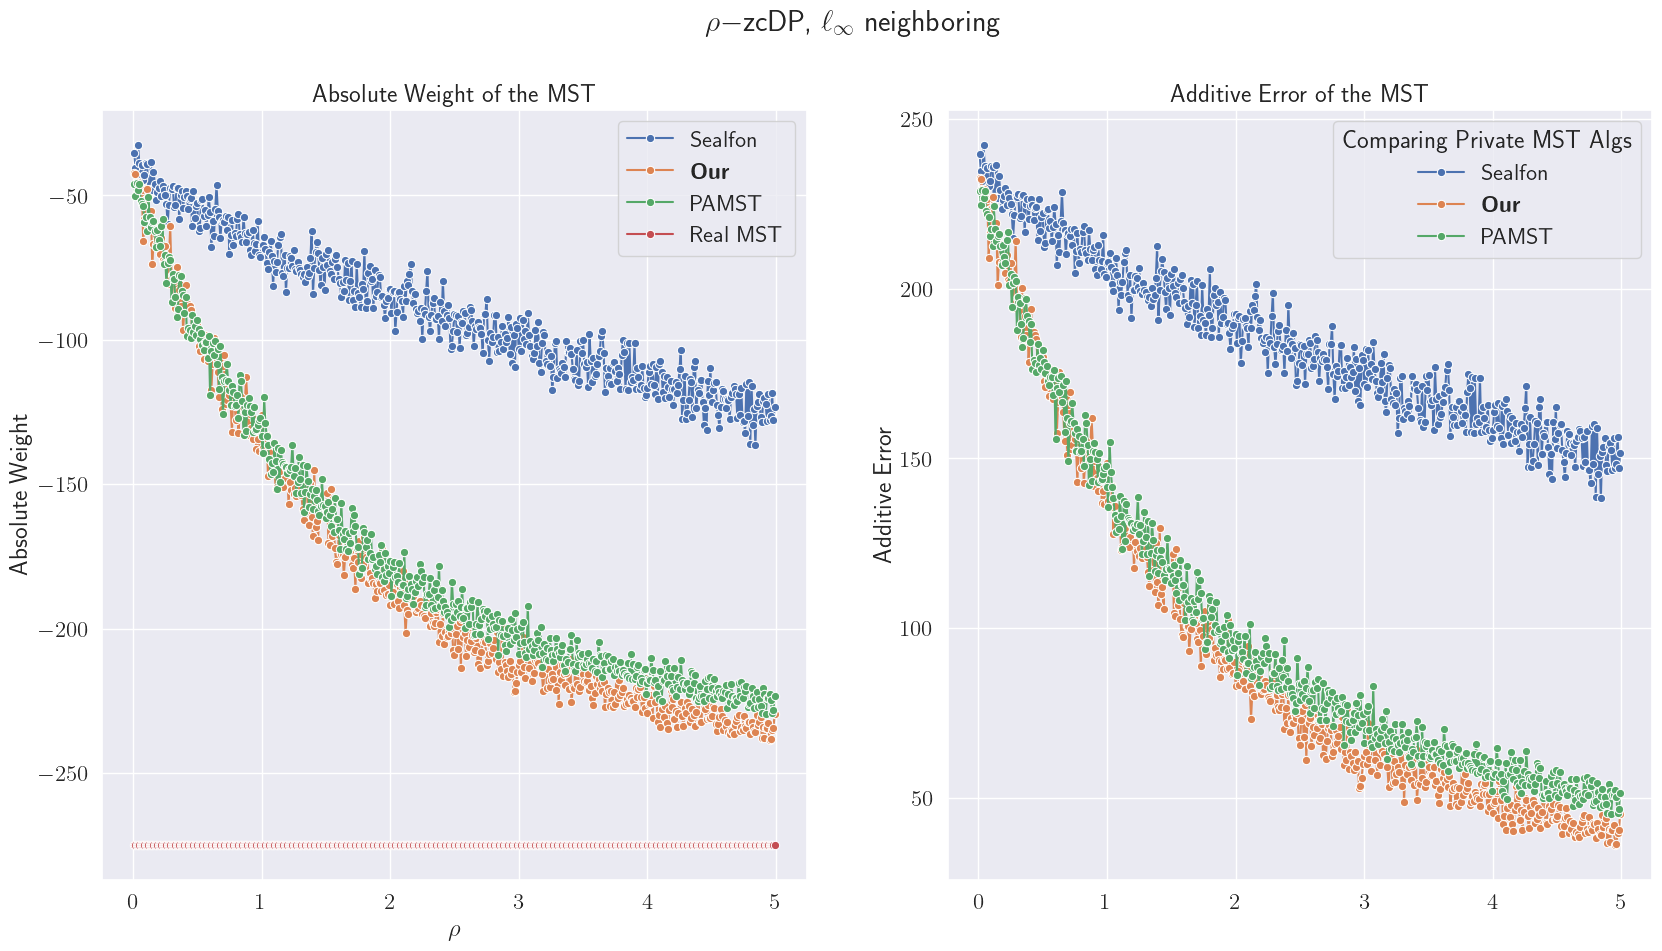

In [10]:
save_results = True # Saving the results?
mutual_information = lambda d: np.log2(d)/d
# Params
rho_values = np.arange(0.01, 5, 0.01)
flip_p = 0.01 # flips bit value: X_i = 1- X_{i-1} with probability p
n = 300
sensitivity = mutual_information(1000) # MI for dataset of size 1000 

G = generate_mi_instance(n, flip_p)
results_mi = compute_approximate_dp(G=G, sensitivity=sensitivity, rho_values=rho_values)

if save_results:
    file_name = "save/mi_n_flip-p{}_sens{}".format(n, flip_p, sensitivity)
    save_results(results=file_name + ".npy", filename=file_name)
    plt.savefig(file_name + ".png")
init_plot(results_mi, rho_values=rho_values)
plt.show()


# Experiment III: Hard-Instance from Sealfon
We are using Sealfons instance to create an hard instance. Not relevant at the moment.

Real MST Weight: 0
[255.88914266403188, 73.5649455387632, 50.96985726099633, 48.898288115691514, 40.195514048130924, 34.16505878569597, 31.81082745181895, 29.132528646722648, 27.275005516515087, 25.888733459683117, 23.241404955174975, 24.005504874179696, 23.533145255571643, 20.797337860565584, 21.92562109770431, 19.855406679112214, 18.290899885832246, 17.861791252409123, 17.803689066680995, 18.946081296922554, 17.6292836437288, 17.30887690144163, 16.712589523084713, 17.22781066524305, 16.195769814656874, 16.151579466303254, 15.0103480695772, 15.72490444887349, 12.868806022550247, 15.174911470724657]


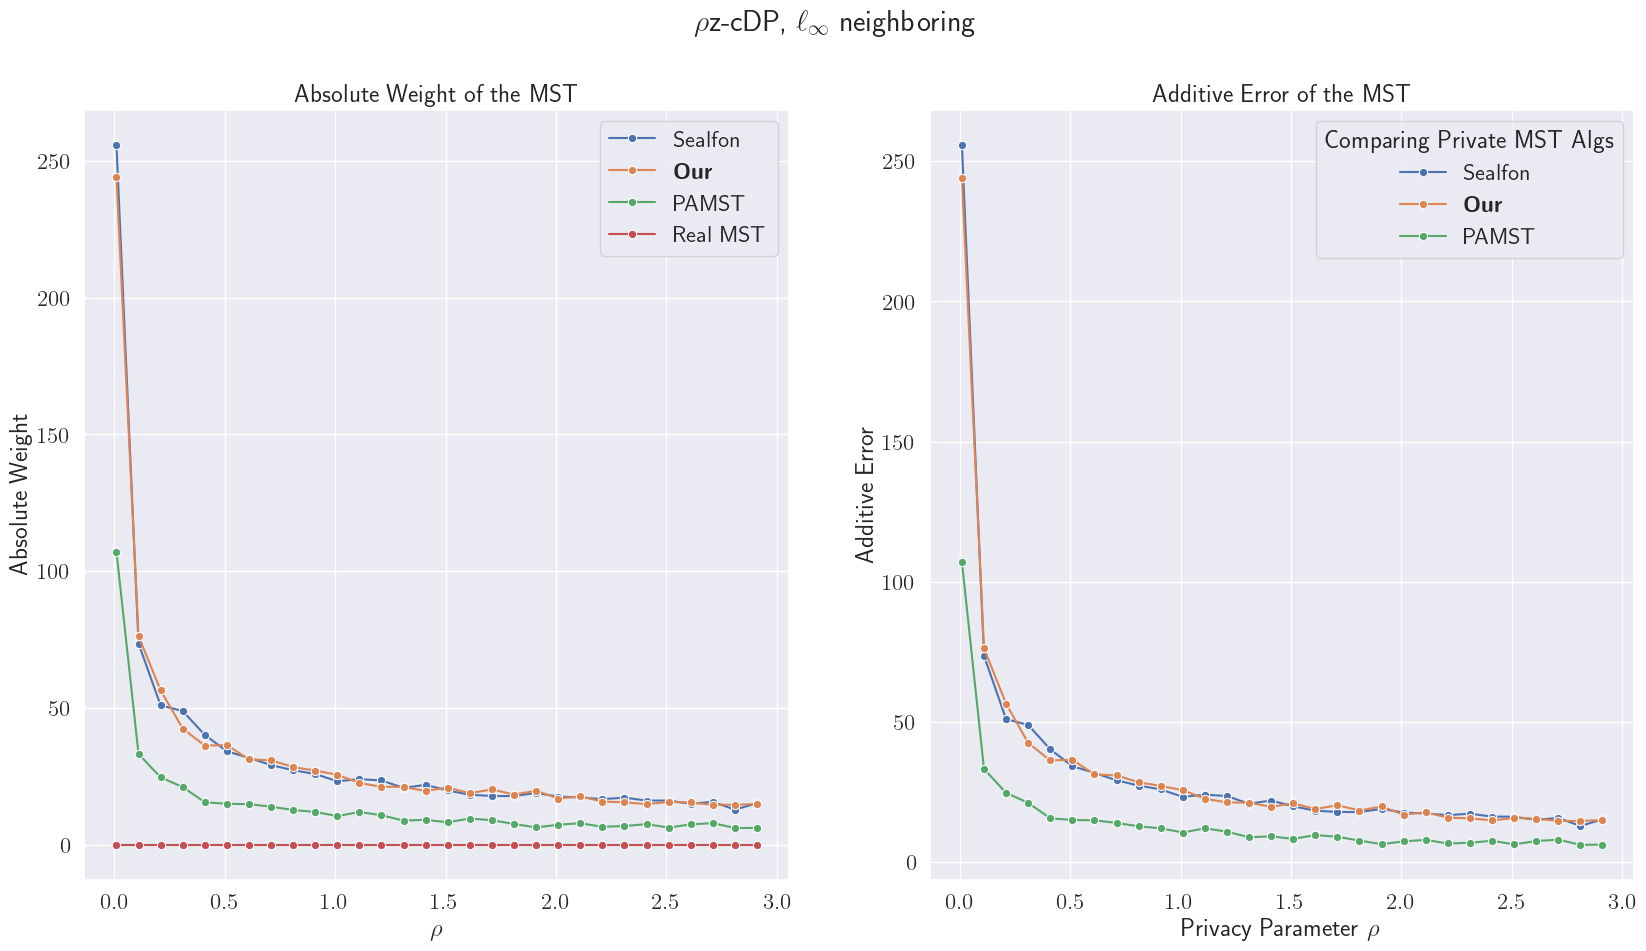

In [73]:
# Privacy Parameters
rho_values = np.arange(0.01, 3, 0.1)
# rho_values = [0.001,0.02]
n = 250
sensitivity = 1

# Generate a enw graph
G = {}
for rho in rho_values:
    G[rho] = generate_hard_instance(n, 1/75* math.sqrt((n-1)/(2*rho))) # is this interesting?
    
# Computing the upper bound
upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n)/(2*rho)]
    
results = compute_approximate_dp(G, sensitivity=sensitivity,rho_values=rho_values )
init_plot(results, rho_values=rho_values)
plt.show()

# Appendix

What comes now is more or less meant for experiments and debugging.

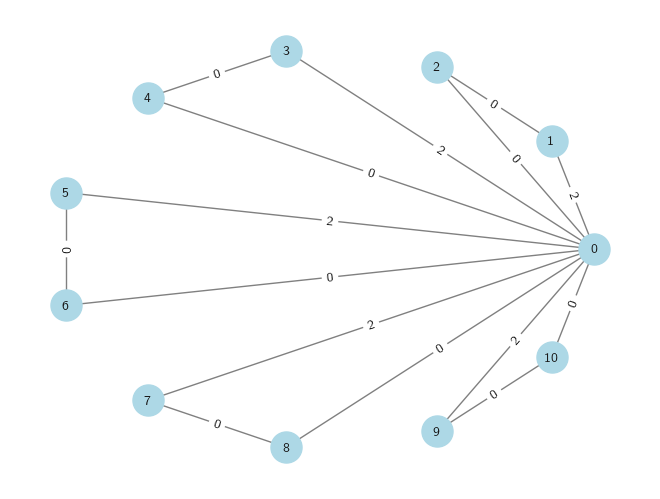

In [17]:
# Visualization of our hard instance
pos = nx.circular_layout(G)

G = generate_hard_instance(5, 1)
T = nx.minimum_spanning_tree(G, algorithm='prim')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.show()


{(0,
  1): Text(-0.19882850523197593, -0.6345080300249896, '-0.9192068641040887'),
 (0,
  2): Text(-0.07087365393847175, -0.42955507614362737, '-0.8596838763959699'),
 (0,
  3): Text(-0.07888746877207485, -0.1447708110222666, '-0.8086059149461139'),
 (0, 4): Text(-0.2550781373439255, 0.1455830414045582, '-0.7631633636805215'),
 (1, 2): Text(0.13274301768718427, -0.3552291889777333, '-0.9192068641040887'),
 (1,
  3): Text(0.12472920285358119, -0.07044492385637255, '-0.8596838763959699'),
 (1,
  4): Text(-0.051461465718269456, 0.21990892857045224, '-0.8086059149461139'),
 (2, 3): Text(0.2526840541470854, 0.13450803002498965, '-0.9192068641040887'),
 (2, 4): Text(0.07649338557523473, 0.42486188245181444, '-0.8596838763959699'),
 (3, 4): Text(0.06847957074163163, 0.7096461475731752, '-0.9192068641040887')}

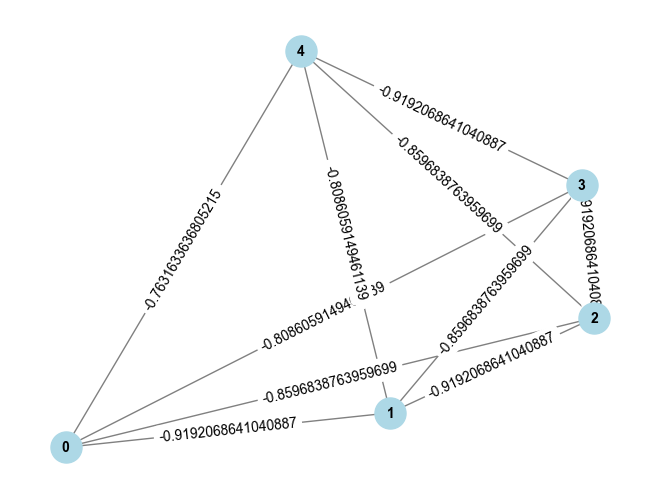

In [2]:
# Visualization MI Cell

G2 = generate_mi_instance(5, 0.01)
pos = nx.spiral_layout(G2)

# Draw the graph
nx.draw(G2, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_size=10)
